In [1]:
import io
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
conjuntos = ['treinamento', 'teste', 'validacao']
base_path = 'dados/processed'
pastas_excluir = ['cleanImage', '?']

for conjunto in conjuntos:
    conjunto_path = os.path.join(base_path, conjunto)
    for nome in os.listdir(conjunto_path):
        full_path = os.path.join(conjunto_path, nome)
        if nome in pastas_excluir and os.path.isdir(full_path):
            print(f"Removendo pasta: {full_path}")
            shutil.rmtree(full_path)

In [3]:
train_dir = 'dados/processed/treinamento'
val_dir   = 'dados/processed/validacao'
test_dir  = 'dados/processed/teste'

In [4]:
def load_images_from_folder(folder):
    images = {}
    for char_folder in os.listdir(folder):
        char_images = []
        for filename in os.listdir(os.path.join(folder, char_folder)):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder, char_folder, filename)
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        char_images.append(img)
        
        images[char_folder] = char_images
    
    return images

In [5]:
def calculate_bin_index(angle):
    temp = (angle / 20.0) - 0.5
    j = math.floor(temp)
    return j

def calculate_center_of_bin(j):
    return round((j + 0.5) * 20.0, 9)

def calculate_value_of_bin(magnitude, angle, j):
    cj = calculate_center_of_bin(j)
    vj = magnitude * ((cj - angle) / 20.0)
    return round(vj, 9)

In [6]:
def compute_histogram(magnitude, angle, num_bins=9):
    histogram = np.zeros(num_bins)
    bin_size = 180 / num_bins

    bin_index = angle / bin_size
    lower = int(np.floor(bin_index)) % num_bins
    upper = (lower + 1) % num_bins
    ratio = bin_index - lower

    histogram[lower] += magnitude * (1 - ratio)
    histogram[upper] += magnitude * ratio

    return histogram

In [ ]:
# def extract_hog_features(image):
#     resized_image = cv2.resize(image, (64, 128))

#     hog = cv2.HOGDescriptor()
#     features = hog.compute(resized_image)
#     if features is None:
#         print("Erro ao extrair características HOG: 'features' é None")
#         return np.array([])
#     # print(f"Dimensões das características HOG: {features.shape}")
#     return np.array(features)

def extract_hog_features(image):
    resized_image = cv2.resize(image, (64, 128))

    Gx = cv2.Sobel(resized_image, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(resized_image, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(Gx ** 2 + Gy ** 2)
    angle = np.arctan2(Gy, Gx) * (180 / np.pi)
    angle[angle < 0] += 180
    angle[angle >= 180] -= 180

    nrows, ncols = magnitude.shape
    num_bins = 9

    hog_cells = []
    for i in range(0, nrows, 8):
        row_cells = []
        for j in range(0, ncols, 8):
            hist = np.zeros(num_bins)
            for dx in range(8):
                for dy in range(8):
                    mag = magnitude[i + dx, j + dy]
                    ang = angle[i + dx, j + dy]
                    hist += compute_histogram(mag, ang, num_bins)
            row_cells.append(hist)
        hog_cells.append(row_cells)

    features = []
    epsilon = 1e-5
    for i in range(len(hog_cells) - 1):
        for j in range(len(hog_cells[0]) - 1):
            block = np.concatenate([
                hog_cells[i][j],
                hog_cells[i][j + 1],
                hog_cells[i + 1][j],
                hog_cells[i + 1][j + 1]
            ])
            norm = np.sqrt(np.sum(block ** 2) + epsilon)
            features.extend(block / norm)

    return np.array(features, dtype=np.float32)

    # Normalização L2
    # hog_features = np.array(hog_features)
    # norm = np.linalg.norm(hog_features) + 1e-7
    # hog_features = hog_features / norm
    # return hog_features.tolist()

In [8]:
def create_features_df(folder):
    if os.path.exists(f'{folder}_features.csv'):
        print(f"Arquivo {folder}_features.csv já existe. Carregando...")
        return pd.read_csv(f'{folder}_features.csv')
    
    print(f"Extraindo HOG features de {folder}...")
    features = []
    images = load_images_from_folder(folder)
    
    for char, char_images in tqdm(images.items(), desc="Processando caracteres"):
        print(f"Processando imagens do caractere: {char}")
        for img in char_images:
            hog_features = extract_hog_features(img)
            features.append([str(char)] + hog_features.tolist())
            
    df = pd.DataFrame(features)
    df.columns = ['label'] + [f'feature_{i}' for i in range(len(df.columns) - 1)]
    df.to_csv(f'{folder}_features.csv', index=False)
    
    return df

In [9]:
df_train = create_features_df(train_dir)
df_val = create_features_df(val_dir)
df_test = create_features_df(test_dir)

Arquivo dados/processed/treinamento_features.csv já existe. Carregando...


/tmp/ipykernel_99001/1820887373.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f'{folder}_features.csv')


Arquivo dados/processed/validacao_features.csv já existe. Carregando...
Arquivo dados/processed/teste_features.csv já existe. Carregando...


/tmp/ipykernel_99001/1820887373.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f'{folder}_features.csv')


In [10]:
df_test

,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_3770,feature_3771,feature_3772,feature_3773,feature_3774,feature_3775,feature_3776,feature_3777,feature_3778,feature_3779
0,D,0.005524,0.006119,0.003025,0.003114,0.065159,0.111617,0.053229,0.034950,0.017633,...,0.000000,0.204630,0.047736,0.069482,0.028630,0.438334,0.468281,0.056262,0.086853,0.047736
1,D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.093984,0.009575,0.130921,0.107945,0.031400,0.031138,0.073658,0.087064,0.150013,0.069254
2,D,0.003788,0.001576,0.001058,0.000578,0.000596,0.000294,0.000421,0.000669,0.000929,...,0.071738,0.023343,0.028695,0.041767,0.038719,0.121071,0.157275,0.087087,0.027432,0.014348
3,D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.104264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,D,0.008023,0.004421,0.002105,0.002174,0.005289,0.003072,0.002985,0.003951,0.004962,...,0.034112,0.002912,0.034296,0.031199,0.018246,0.120542,0.178628,0.089294,0.064276,0.011291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,Q,0.114584,0.153986,0.227768,0.187978,0.341856,0.235922,0.000000,0.000000,0.000000,...,0.000774,0.000757,0.000802,0.001671,0.001674,0.000850,0.000667,0.000801,0.001050,0.000000
5990,Q,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.030137,0.046689,0.101996,0.101996,0.037149,0.001516,0.000000
5991,Q,0.006192,0.002168,0.003124,0.003013,0.004444,0.006883,0.004981,0.002992,0.006130,...,0.004096,0.002316,0.001733,0.001387,0.000954,0.002024,0.002468,0.002389,0.002017,0.000983
5992,Q,0.004843,0.017289,0.033636,0.025114,0.061816,0.104236,0.041373,0.034218,0.016533,...,0.100745,0.653703,0.001940,0.000711,0.000982,0.017619,0.017079,0.000761,0.109234,0.273527


In [11]:
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [12]:
X_train = df_train.drop(columns=['label'])

labels = sorted(df_train['label'].unique())
dict_labels = {label: idx for idx, label in enumerate(labels)}
y_train = df_train['label']
X_val = df_val.drop(columns=['label'])
y_val = df_val['label']
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

In [13]:
print(f'Different types in X_train: {X_train.dtypes.unique()}')
print(f'Different types in y_train: {y_train}')

Different types in X_train: [dtype('float64')]
Different types in y_train: 0        D
1        D
2        D
3        D
4        D
        ..
47863    Q
47864    Q
47865    Q
47866    Q
47867    Q
Name: label, Length: 47868, dtype: object


Treinando modelo: RandomForestClassifier
Acurácia - Treinamento (RandomForestClassifier): 1.0
Acurácia - Validação (RandomForestClassifier): 0.7749416082749416
Acurácia - Teste (RandomForestClassifier): 0.7819486152819486
Relatório de Classificação - Treinamento (RandomForestClassifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1350
           2       1.00      1.00      1.00      1384
           3       1.00      1.00      1.00      1323
           4       1.00      1.00      1.00      1333
           5       1.00      1.00      1.00      1280
           6       1.00      1.00      1.00      1405
           7       1.00      1.00      1.00      1344
           8       1.00      1.00      1.00      1312
           9       1.00      1.00      1.00      1281
           A       1.00      1.00      1.00      1308
           B       1.00      1.00      1.00      1303
        

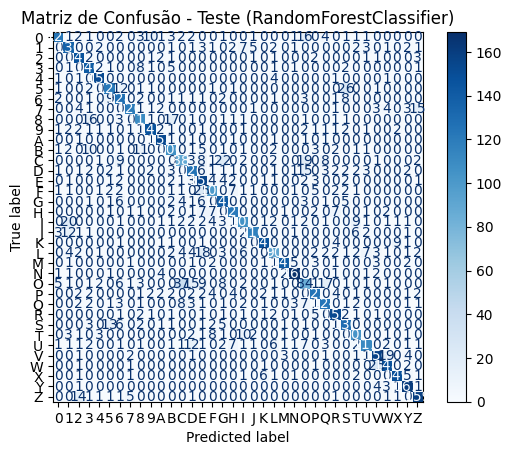

Treinando modelo: DecisionTreeClassifier
Acurácia - Treinamento (DecisionTreeClassifier): 1.0
Acurácia - Validação (DecisionTreeClassifier): 0.40173506840173506
Acurácia - Teste (DecisionTreeClassifier): 0.3890557223890557
Relatório de Classificação - Treinamento (DecisionTreeClassifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1350
           2       1.00      1.00      1.00      1384
           3       1.00      1.00      1.00      1323
           4       1.00      1.00      1.00      1333
           5       1.00      1.00      1.00      1280
           6       1.00      1.00      1.00      1405
           7       1.00      1.00      1.00      1344
           8       1.00      1.00      1.00      1312
           9       1.00      1.00      1.00      1281
           A       1.00      1.00      1.00      1308
           B       1.00      1.00      1.00      1303
       

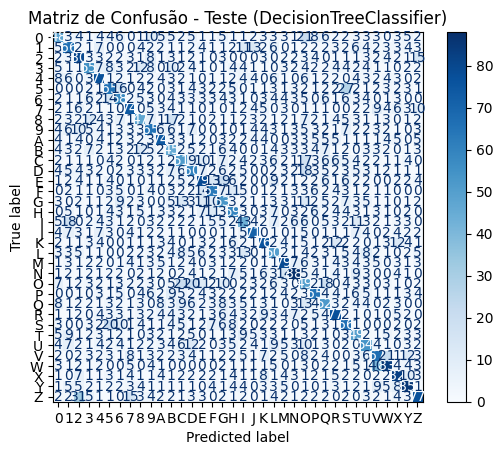

Treinando modelo: MLPClassifier
Acurácia - Treinamento (MLPClassifier): 1.0
Acurácia - Validação (MLPClassifier): 0.8390056723390057
Acurácia - Teste (MLPClassifier): 0.8415081748415082
Relatório de Classificação - Treinamento (MLPClassifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1166
           1       1.00      1.00      1.00      1350
           2       1.00      1.00      1.00      1384
           3       1.00      1.00      1.00      1323
           4       1.00      1.00      1.00      1333
           5       1.00      1.00      1.00      1280
           6       1.00      1.00      1.00      1405
           7       1.00      1.00      1.00      1344
           8       1.00      1.00      1.00      1312
           9       1.00      1.00      1.00      1281
           A       1.00      1.00      1.00      1308
           B       1.00      1.00      1.00      1303
           C       1.00      1.00      1.00      1229

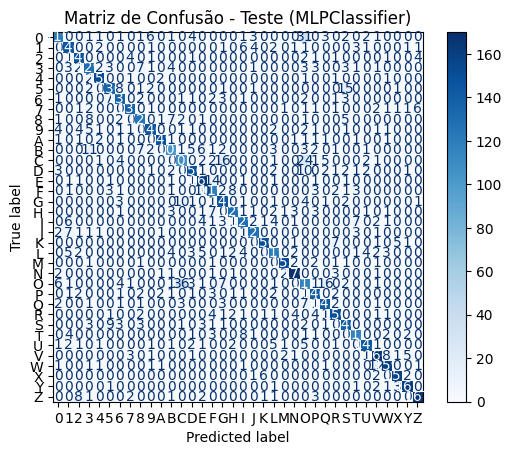

Treinando modelo: KNeighborsClassifier
Acurácia - Treinamento (KNeighborsClassifier): 0.8757625135790089
Acurácia - Validação (KNeighborsClassifier): 0.7811144477811145
Acurácia - Teste (KNeighborsClassifier): 0.7851184517851184
Relatório de Classificação - Treinamento (KNeighborsClassifier):
              precision    recall  f1-score   support

           0       0.70      0.89      0.78      1166
           1       0.80      0.94      0.86      1350
           2       0.89      0.95      0.92      1384
           3       0.84      0.92      0.88      1323
           4       0.96      0.97      0.97      1333
           5       0.82      0.86      0.84      1280
           6       0.87      0.89      0.88      1405
           7       0.95      0.90      0.92      1344
           8       0.84      0.88      0.86      1312
           9       0.93      0.93      0.93      1281
           A       0.98      0.97      0.97      1308
           B       0.74      0.84      0.79      1303
   

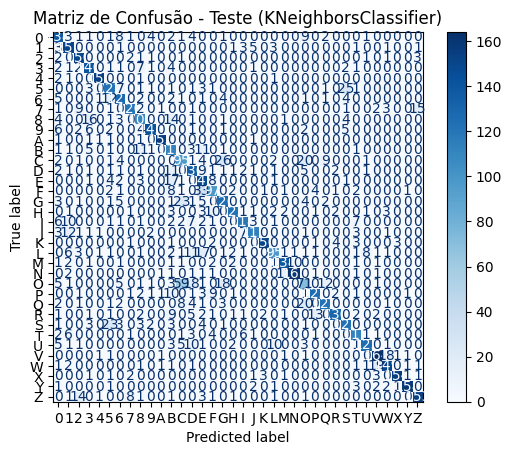

In [14]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    # SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    MLPClassifier(random_state=42, max_iter=500),
    KNeighborsClassifier()
]

for model in models:
    print(f"Treinando modelo: {model.__class__.__name__}")
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    print(f"Acurácia - Treinamento ({model.__class__.__name__}):", model.score(X_train, y_train))
    print(f"Acurácia - Validação ({model.__class__.__name__}):", model.score(X_val, y_val))
    print(f"Acurácia - Teste ({model.__class__.__name__}):", model.score(X_test, y_test))
    
    print(f"Relatório de Classificação - Treinamento ({model.__class__.__name__}):")
    print(classification_report(y_train, y_pred_train))
    print(f"Relatório de Classificação - Validação ({model.__class__.__name__}):")
    print(classification_report(y_val, y_pred_val))
    print(f"Relatório de Classificação - Teste ({model.__class__.__name__}):")
    print(classification_report(y_test, y_pred_test))
    
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusão - Teste ({model.__class__.__name__})")
    plt.show()